In [1]:
# %pip install -q numpyro getdist
# %pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples, gaussian_mixtures

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, hessian, vmap, tree, debug
from jax.experimental.ode import odeint

import jax_cosmo as jc
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.kernels import fftk

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density


%matplotlib inline
%load_ext autoreload
%autoreload 2

feynmangpu04.cluster.local


gpu


# Probabilistic Programming Language: introductory example

In [2]:
# To fully define a probabilistic model, we need
# 1. to define its simulator
def simulate(seed):
    rng = np.random.RandomState(seed)
    x = rng.randn()
    y = rng.randn() + x**2
    return y

print(simulate(seed=42))

# 2. to define its associated log joint density
from scipy.stats import norm
log_prior = lambda x: norm.logpdf(x, loc=0, scale=1)
log_lik = lambda x, y: norm.logpdf(y, loc=x**2, scale=1)
log_joint= lambda x, y: log_lik(y, x) + log_prior(x)

# 3. possibly, define its gradients, or its Hessian, or other derived functionals...
grad_log_prior = lambda x: x**2
grad_log_lik = lambda x, y: np.stack([2 * x * (y - x**2), (y - x**2)])
grad_log_joint = lambda x, y: grad_log_lik(y, x) + np.stack([grad_log_prior(x), np.zeros_like(y)])
# Hessian left as an exercise...

# 4. Ideally, we would like to easily invert the model, i.e. condition on some variables and infer the others
# This is often done with the help of external MCMC samplers packages

0.1084606486304816


To fully define a probabilistic model, we need
1. to define its simulator
2. to define its associated log joint density
3. possibly, define its gradients, or its Hessian, or other derived functionals...
4. Ideally, we would like to easily invert and simplify the model, i.e. condition and marginalize on some variables and infer the others.

> What if we could only do step 1.?

This is the goal of Probabilistic Programming Language
Other PPLs: Stan, PyMC...

One NumPyro advantage is to be powered by JAX, benefiting directly from:
* GPU acceleration
* JIT compilation
* vectorization/parallelization
* automatic differentiation

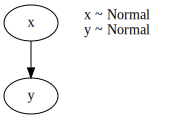

In [3]:
def model():
    x = sample('x', dist.Normal(0, 1))

    ###############
    # TODO: sample y from a Normal distribution with mean x**2 and std 1
    y = sample('y', dist.Normal(x**2, 1))
    # y = 
    ###############
    
    return y

render_model(model, render_distributions=True)

2024-11-18 09:39:03.956238: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


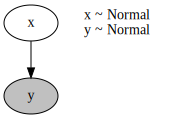

In [4]:
# Handle random seeds for reproducibility
seeded_model = seed(model, 42)

# Sample from model
y_obs = dict(y=seeded_model())

# Condition model on variable
obs_model = condition(model, y_obs)
render_model(obs_model, render_distributions=True)

In [5]:
# Compute log probability of model
log_joint = lambda params: log_density(model,(),{},params)[0]
print(log_joint({'x': 0., 'y': 0.}))

-1.837877


In [6]:
vlim = -3,3
n_discr = 100
xs, ys = jnp.linspace(*vlim, n_discr), jnp.linspace(*vlim, n_discr)
xx, yy = jnp.meshgrid(xs, ys)
xy = {'x': xx, 'y': yy}
logps = vmap(vmap(log_joint))(xy)

###################
# TODO: compute the force field associated to the log joint. 
# Don't forget xx and yy are 2D arrays, you will need to vectorize
forces = vmap(vmap(grad(log_joint)))(xy)
# forces = 
###################

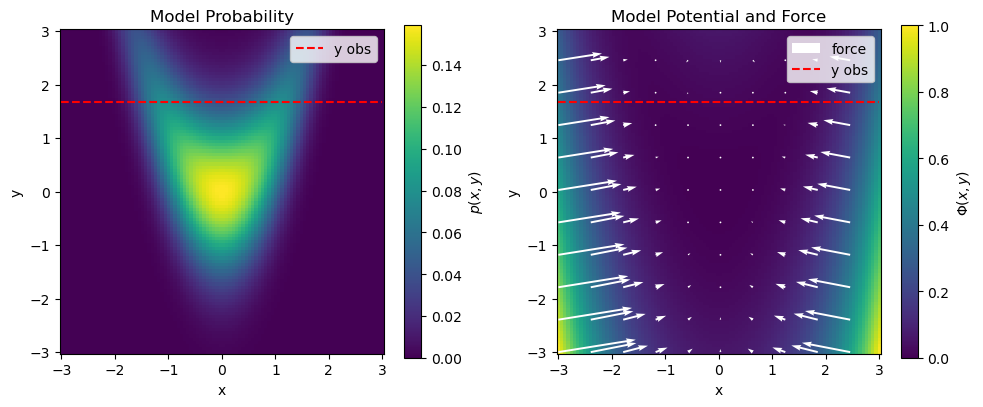

In [7]:
# @title Plot model probability, potential, and force fields
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.pcolormesh(xy['x'], xy['y'], jnp.exp(logps), cmap='viridis')
plt.hlines(y_obs['y'], *vlim, color='r', linestyle='--', label='y obs')
plt.colorbar(label='$p(x,y)$'), plt.gca().set_aspect(1)
plt.xlabel('x'), plt.ylabel('y')
plt.title('Model Probability')
plt.legend()

plt.subplot(122)
plt.pcolormesh(xy['x'], xy['y'], -logps, cmap='viridis')
step = 10
plt.quiver(xy['x'][::step,::step], xy['y'][::step,::step], 
           forces['x'][::step,::step], forces['y'][::step,::step], 
           color='white', label='force')
plt.hlines(y_obs['y'], *vlim, color='r', linestyle='--', label='y obs')
plt.colorbar(label='$\\Phi(x,y)$'), plt.gca().set_aspect(1)
plt.xlabel('x'), plt.ylabel('y')
plt.title('Model Potential and Force')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
kernel = infer.NUTS(obs_model)
mcmc = infer.MCMC(kernel, num_warmup=100, num_samples=1000, num_chains=8, chain_method='vectorized')
mcmc.run(jr.key(42))
samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 1100/1100 [00:03<00:00, 305.72it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.02      0.99      0.03     -1.38      1.52    792.62      1.01

Number of divergences: 18


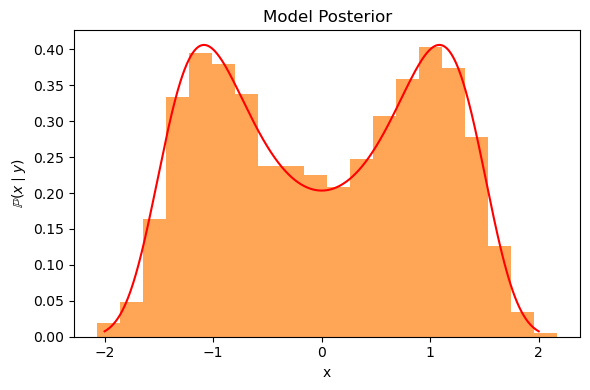

In [9]:
# @title Plot posterior samples
plt.figure(figsize=(6,4))
xs = jnp.linspace(-2,2,1000)
logp_fn = lambda x: log_density(obs_model,(),{},dict(x=x))[0]
logps = jnp.exp(vmap(logp_fn)(xs))
logposts = logps / np.trapz(logps, xs)
plt.plot(xs, logposts, color='red')
plt.hist(samples['x'], density=True, color='tab:orange', alpha=0.7, bins=20)
plt.xlabel('x'), plt.ylabel('$\\mathbb{P}(x \\mid y)$')
plt.title('Model Posterior')
plt.tight_layout()

# Power spectrum model

## Model
To handle cosmology and compute power spectrum, we will use [JaxCosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) from the *Differentiable Universe Initiative*.

Here `linear_matter_power` uses Eisenstein & Hu matter transfer function approximation ([Einsenstein and Hu, 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...496..605E/abstract)).

For a (differentiable) Einstein-Boltzmann solver in JAX, see [DISCO-DJ](https://github.com/ohahn/DISCO-EB).

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

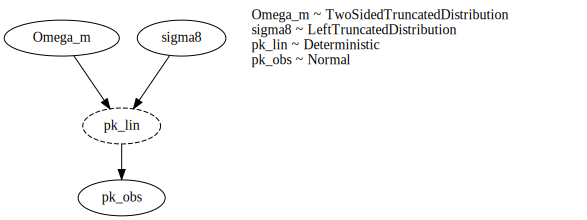

In [34]:
# @title Define a simple power spectrum model
def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c = Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


def linear_pk_interp(cosmology, a=1., n_interp=128):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmology, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn


def prior_model():
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.2, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81, 0.2, low=0.))
    return dict(Omega_m = Omega_m, sigma8 = sigma8)


def lik_model(Omega_m, sigma8, z, ks):
    cosmology = get_cosmology(Omega_m, sigma8)
    pk_fn = linear_pk_interp(cosmology, a=1/(1+z))
    pk_lin = deterministic('pk_lin', pk_fn(ks))
    pk_obs = sample('pk_obs', dist.Normal(pk_lin, 30/ks))
    return pk_obs


def model(z, ks):
    params = prior_model()
    return lik_model(**params, z=z, ks=ks)

# Model configuration
config = {'z' : 1.,
          'ks' : jnp.linspace(10e-3, 0.5, 50),}

# Names and labels for plots
names = ["Omega_m", "sigma8"]
labels = ["\\Omega_m", "\\sigma_8"]

model = partial(model, **config)
render_model(model, render_distributions=True)

The model defines a joint distributions over variables, i.e. it defines the random variable $\Omega_m, \sigma_8, P_\text{obs}$.

The distribution of observed $P_\text{obs}$ is sometimes called the **evidence** or the **prior predictive distribution**, because it is the distribution predicted by the prior on $\Omega_m, \sigma_8$. Let's sample from it.

In [3]:
##################
# TODO: sample 10 000 realizations from the unconditionned model, i.e. the prior predictive distribution
prior_preds = infer.Predictive(model, num_samples=10_000, parallel=True)(jr.PRNGKey(42))
# prior_preds =
##################

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Before plotting it, let us also assume a true cosmology $\Omega^0 := \Omega_m^0, \sigma_8^0$ and generate a corresponding realization $\Omega_m^0, \sigma_8^0, P_\text{obs}^0$. We will define it as the true realization.

In [4]:
# Let us set a true cosmology and generate a corresponding realization
true_cosmo = {'Omega_m': 0.3, 'sigma8': 0.8}

##################
# TODO: sample 1 realization from the true cosmology
true_real = infer.Predictive(model, params=true_cosmo, num_samples=1, parallel=True)(jr.PRNGKey(45))
# true_real =
##################

print(true_real.keys())

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


dict_keys(['Omega_m', 'pk_lin', 'pk_obs', 'sigma8'])


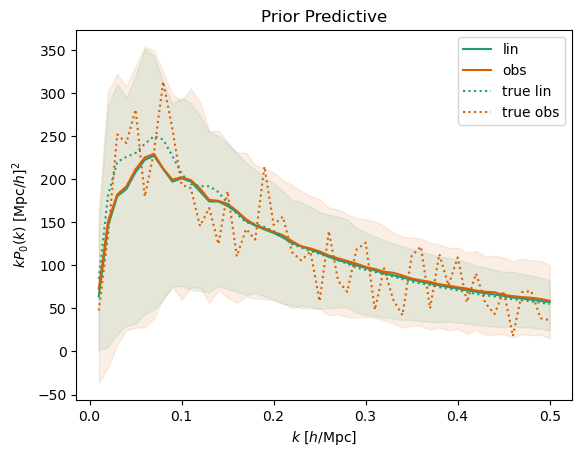

In [5]:
# @title Plot prior predictive realizations
def hdi(x, proba=.95, axis=0):
    """
    Compute the Highest Density Interval (HDI),
    i.e. the smallest interval of proba `proba`.
    """
    x = np.moveaxis(x, axis, 0)
    x_sort = jnp.sort(x, axis=0)
    n = x.shape[0]
    # Round for better estimation at low number of sample, and handle also the case proba close to 1.
    i_length = min(int(jnp.rint(proba * n)), n-1)

    intervals_low = x_sort[: (n - i_length)] # no need to consider all low bounds
    intervals_high = x_sort[i_length:]  # no need to consider all high bounds
    intervals_length = intervals_high - intervals_low # all intervals with given proba
    i_low = intervals_length.argmin(axis=0)
    i_high = i_low + i_length
    hdi_low = jnp.take_along_axis(x_sort, i_low[None], 0)[0]
    hdi_high = jnp.take_along_axis(x_sort, i_high[None], 0)[0]
    return jnp.stack([hdi_low, hdi_high], axis=axis)

cmap = plt.get_cmap('Dark2')
def plot_pks(pks, *args, c, **kwargs):
    plot_pk = lambda pk, *args, **kwargs: plt.plot(ks, ks*pk, *args, **kwargs)
    ks = config['ks']
    plot_pk(jnp.median(pks, 0), *args, c=c, **kwargs)
    if len(pks) > 1:
        plt.fill_between(ks, *hdi(pks, 0.68)*ks, color=c, alpha=0.1)
    plt.xlabel("$k$ [$h$/Mpc]"), plt.ylabel(f"$k P_{0}(k)$ [Mpc/$h$]$^2$") 

plot_pks(prior_preds['pk_lin'], c=cmap(0), label='lin')
plot_pks(prior_preds['pk_obs'], c=cmap(1), label='obs')
plot_pks(true_real['pk_lin'], ':', c=cmap(0), label='true lin')
plot_pks(true_real['pk_obs'], ':', c=cmap(1), label='true obs')
plt.title('Prior Predictive')
plt.legend(), plt.show();

## Fisher forecast

We want to compute the **Cramér-Rao bound at a fiducial cosmology**. For any estimator $\hat \theta$ such that $\mathbb E[\hat \theta(x) \mid \theta]= \theta$, we have
<!-- $$\mathbb E[(\hat \theta(x) - \theta)(\hat \theta(x) - \theta)^\top \mid \theta] \succeq I^{-1}(\theta)$$ -->
$$\operatorname{\mathbb C\!ov}[\hat \theta(x) \mid \theta] \succeq I[\theta]^{-1}$$ 
where $$I[\theta] := \mathbb E[\nabla^2_\theta \Phi(x \mid \theta) \mid \theta]\quad ; \quad \Phi(x \mid \theta) := -\log p(x \mid \theta)$$
In our case, we compute $$ \hat I[\Omega^0] := \frac{1}{n}\sum_{i=1}^n \nabla^2_{\Omega^0} \Phi(P_\text{obs}^i \mid \Omega^0), \quad (P_\text{obs}^i)_{i=1}^n \overset{\perp\!\!\!\perp}{\sim} P_\text{obs} \mid \Omega_0$$
Such that $\hat I[\Omega^0] \simeq I[\Omega^0]$

In [6]:
def fisher_fn(fiduc_cosmo, lik_model, num_samples, **config):
    # Sample from fiducial cosmology
    lik_model = partial(lik_model, **fiduc_cosmo, **config)
    fiduc_preds = infer.Predictive(lik_model, num_samples=num_samples, parallel=True)(jr.PRNGKey(45))

    # Compute Hessians
    potential = lambda cosmo, obs: -log_density(lik_model, (), cosmo, obs)[0]

    #############
    # TODO: Compute the Hessian function of the potential (with respect to cosmology) 
    hessian_fn = hessian(potential)
    # hessian_fn = 
    #############

    hessians_fn = vmap(lambda obs: hessian_fn(fiduc_cosmo, obs))
    hessians = hessians_fn({'pk_obs':fiduc_preds['pk_obs']})

    # Compute Fisher matrix
    fisher = tree.map(lambda x: x.mean(0), hessians)
    fisher_matrix = jnp.array([[fisher[k1][k2] for k1 in fisher] for k2 in fisher])

    # Return mean and covariance
    cov = jnp.linalg.inv(fisher_matrix)
    mean = jnp.array([fiduc_cosmo[k] for k in fiduc_cosmo])
    return mean, cov

In [7]:
fisher_fn = jit(partial(fisher_fn, lik_model=lik_model, num_samples=100, **config))
mean, cov = fisher_fn(true_cosmo)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

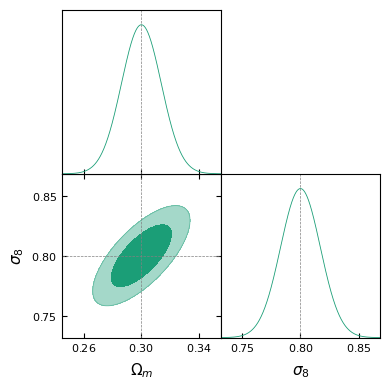

In [8]:
# @title Plot Fisher forecast
gd_fisher = gaussian_mixtures.GaussianND(mean, cov, names=names, labels=labels, label='Fisher')
g = plots.get_subplot_plotter()
g.triangle_plot(gd_fisher, filled=True, contour_colors=[cmap(0)], markers=true_cosmo)

## Posterior

Fisher forecast is a forecast. It talks about optimal variance of unbiased estimators, **at a fiducial point**. It does not depend on observations.

Now we have an observation $P_\text{obs}^0$, so we want the posterior $\Omega \mid P_\text{obs}^0$ and its associated quantities (mean, std, quantiles, highest density regions...)

We start by conditioning the model, which consists in setting some variables as observed, with some value.

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

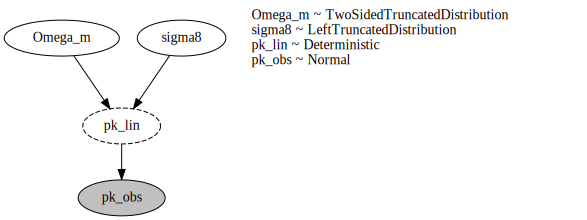

In [9]:
# Condition model on observation
obs_model = condition(model, {'pk_obs':true_real['pk_obs']})
render_model(obs_model, render_distributions=True)

Now we need to sample from this new model. This is not an easy task!

Bayesian inversion is equivalent to computing integrals. But formal integration is in general undecidable (Richardson theorem), and numerical integration is inevitably limited by the evaluation/sampling cost and by the integrand roughness and dimensionality (e.g. [Novak, 2014](http://arxiv.org/abs/1409.6714)).

Nevertheless, if we are ready to pay the numerical cost, some methods can cleverly leverage integrand properties such as differentiability.

### Basic MCMC: Metropolis-Hastings
[demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

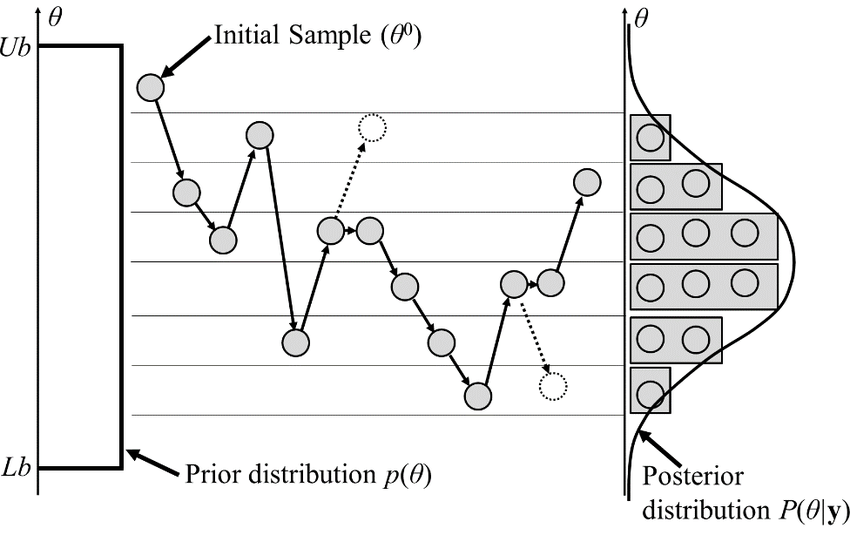

### Gradient based MCMC: Hamiltonian Monte Carlo

* To travel farther, add inertia
    1. Augment the sampling space by a momentum space.
    2. At each step sample a momentum
    3. Follow the Hamiltonian dynamic

* More formaly
    1. We augment the target $p(q \mid x_0)$ into $p(q , p \mid x_0) := e^{-H(q,p)}$, where $$H(q,p) := -\log p(q \mid x_0) + \frac 1 2 p^\top M^{-1} p$$
    2. At each proposal step, $p \sim \mathcal N(0,M)$
	3. Follow the Hamiltonian trajectory for some length$$\dot q = \partial_p H \quad;\quad \dot p = -\partial_q H$$Then the arrival is the proposal.
* Way less correlated than MH, cf. [demo](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html)



In [10]:
# Sample from posterior
# No need to jit, NumPyro will do it for us.
kernel = infer.NUTS(obs_model, init_strategy=infer.init_to_sample())
mcmc = infer.MCMC(kernel, num_warmup=100, num_samples=400, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("n_evals:", extra['num_steps'].sum())
mcmc.print_summary()

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

n_evals: 9762

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.28      0.32    588.43      1.00
    sigma8      0.79      0.02      0.79      0.77      0.82    581.22      1.00

Number of divergences: 0


In [ ]:
# @title Alternative samplers
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH

# Choose an alternative sampler
sampler = "MALA"

if sampler == "MALA":
    kernel = MALA(model=obs_model, init_strategy=infer.init_to_sample(), step_size=1e-4)
elif sampler == "MH":
    def new_state_fn(state, key):
        diffus = [dist.Normal(jnp.zeros(len(state)), 0.1*jnp.ones(len(state))).sample(key)]
        return tree.map(lambda x,y:x+y, state, diffus)
    kernel = MH(model=obs_model, new_state_fn=new_state_fn, init_strategy=infer.init_to_sample())

# Sample from posterior
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=10_000)
mcmc.run(jr.key(43))
samples_brw = mcmc.get_samples()
mcmc.print_summary()

2024-11-17 20:34:12.196311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#curr

Removed no burn in


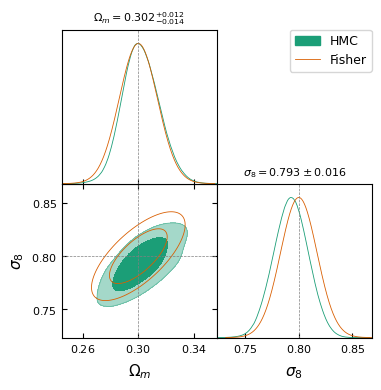

In [12]:
# @title Plot posteriors
def get_gdsamples(samples, names, labels, label):
    return MCSamples(samples=[samples[k] for k in names], names=names, labels=labels, label=label)

roots = []
roots.append(get_gdsamples(samples, names, labels, 'HMC'))
roots.append(gd_fisher)
# roots.append(get_gdsamples(samples_brw, names, labels, 'LMC'))
# roots.append(get_gdsamples(prior_preds, names, labels, 'Prior'))

g = plots.get_subplot_plotter()
g.triangle_plot(roots=roots, 
                title_limit=1, 
                filled=[True, False], 
                contour_colors=[cmap(i) for i in range(len(roots))],
                markers=true_cosmo)

In [13]:
##################
# TODO: sample 10 000 realizations from the conditionned model, i.e. the posterior predictive distribution
post_preds = infer.Predictive(model, samples, num_samples=10_000, parallel=True)(jr.PRNGKey(43))
# post_preds =
##################

/tmp/ipykernel_1804518/641275721.py:3: UserWarning: Sample's batch dimension size 1600 is different from the provided 10000 num_samples argument. Defaulting to 1600.
  post_preds = infer.Predictive(model, samples, num_samples=10_000, parallel=True)(jr.PRNGKey(43))
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more

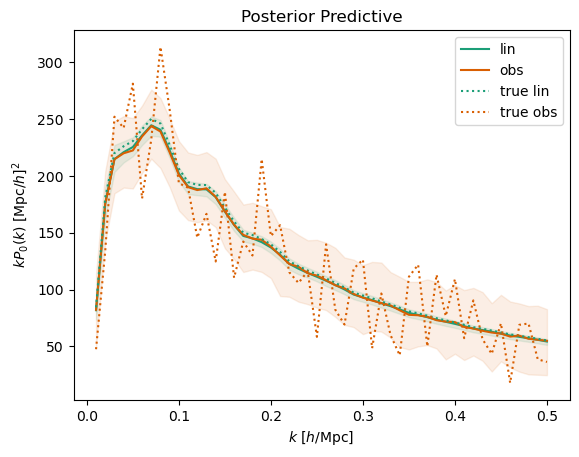

In [14]:
# @title Plot posterior predictive realizations
plot_pks(post_preds['pk_lin'], c=cmap(0), label='lin')
plot_pks(post_preds['pk_obs'], c=cmap(1), label='obs')
plot_pks(true_real['pk_lin'], ':', c=cmap(0), label='true lin')
plot_pks(true_real['pk_obs'], ':', c=cmap(1), label='true obs')
plt.title('Posterior Predictive')
plt.legend(), plt.show();

# N-body model

## N-body with JaxPM

In [10]:
from PIL import Image
def load_image(im_path):
    img = Image.open(im_path).convert("L")
    return np.array(img)

def load_mesh(im_path, depth):
    img = load_image(im_path)
    display(img)
    mesh = jnp.broadcast_to(img[::-1].T[...,None], (*img.shape, depth))
    print(f"{mesh.shape=}")
    return (1 - mesh.astype(jnp.float32) / 255) * 10

from matplotlib import animation, rc
rc('animation', html='html5')

def plot_mesh(meshes, i, vlim, cmap="binary", **config):
    mesh_shape, box_shape = config['mesh_shape'], config['box_shape']
    xx, yy = np.indices(mesh_shape[:2]) * (box_shape/mesh_shape)[:2,None,None]
    vmin, vmax = vlim

    quad = plt.pcolormesh(xx, yy, meshes[i].mean(-1), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.xlabel("$x$ [Mpc/$h$]"), plt.ylabel("$y$ [Mpc/$h$]")
    plt.gca().set_aspect(1)
    return quad

def plot_meshes(meshes, titles=None, joint_scale=False, cmap="binary", **config):
    meshes = jnp.asarray(meshes)
    if joint_scale:
        vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    else:
        vlim = None,None

    plt.figure(figsize=(6*len(meshes), 6))
    for i_mesh, mesh in enumerate(meshes):
        plt.subplot(1, len(meshes), i_mesh+1)
        plot_mesh(meshes, i_mesh, vlim, cmap, **config)

        if titles is not None:
            plt.title(titles[i_mesh])
        if not joint_scale:
            plt.colorbar()
    plt.tight_layout()

def animate_meshes(meshes, cmap="binary", **config):
    meshes = jnp.asarray(meshes)
    vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    quad = plot_mesh(meshes, 0, vlim, cmap, **config)
    plt.colorbar()

    def update(i):
        if i < len(meshes):
            quad.set_array(meshes[i].mean(-1))
        return quad,

    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+10, interval=100, blit=True)
    plt.close()
    display(anim)

Galaxy surveys build 3D maps of the universe by measuring galaxy redshifts. From such galaxy catalogs, we can observe the Baryonic Acoustic Oscillations (BAO), a manifestation of the evolved primordial fluctuations...

Wait actually, it is not the BAO, it is BaoBan, the wild coyote and DESI embassador!

How is it possible that the matter primordial fluctuations collapsed into this capricious face?

Could we reconstruct its initial conditions?

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

mesh.shape=(64, 64, 4)


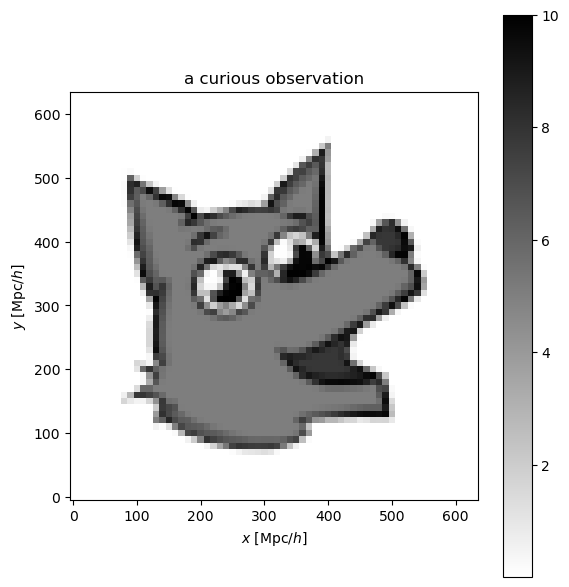

In [11]:
# im_path = "./figs/BaoBan_128.png"
im_path = "./figs/BaoBan_w64.png"
obs_mesh = load_mesh(im_path, depth=4)

config = {
    'mesh_shape': obs_mesh.shape,
    'box_shape': np.array(obs_mesh.shape) * 10, # in Mpc/h
    'a_lpt': 0.01,
    'a_obs': 1.,
    'std_obs': .1,
    'n_snapshots': 30,
}

plot_meshes([obs_mesh], ["a curious observation"], **config)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

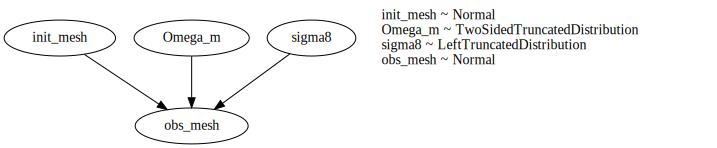

In [12]:
# @title Define a simple matter density field model
def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c = Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


def linear_pk_interp(cosmology, a=1., n_interp=128):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmology, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn


def get_init_mesh(init_mesh_, cosmology,
                  mesh_shape, box_shape, **config):
    """
    Return initial conditions at a=1 from latent params.
    """
    # Compute initial power spectrum
    pk_fn = linear_pk_interp(cosmology)
    kvec = fftk(mesh_shape)
    k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, mesh_shape, box_shape))**0.5
    pk_mesh = pk_fn(k_box) * (mesh_shape / box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units

    # Apply transfer function
    delta_k = jnp.fft.rfftn(init_mesh_)
    delta_k *= pk_mesh**0.5
    init_mesh = jnp.fft.irfftn(delta_k)
    return init_mesh


def nbody(init_mesh, cosmology,
          mesh_shape, a_lpt, a_obs, n_snapshots, **config):
    """
    Compute matter field at a_lpt then evolve it to a_obs.
    """
    # Initial displacement
    pos = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}
    dx, p, f = lpt(cosmology, init_mesh, pos, a_lpt)

    # Evolve the simulation forward
    snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
    pos, p = odeint(make_ode_fn(mesh_shape), [pos+dx, p], snapshots, cosmology, rtol=1e-3, atol=1e-3)
    return jnp.stack([cic_paint(jnp.zeros(mesh_shape), pos_i) for pos_i in pos])


def mean_model(init_mesh, Omega_m, sigma8, **config):
    cosmology = get_cosmology(Omega_m, sigma8)
    init_mesh = get_init_mesh(init_mesh, cosmology, **config) ###
    meshes = nbody(init_mesh, cosmology, **config)
    return meshes


def prior_model(mesh_shape, **config):
    init_mesh = sample('init_mesh', dist.Normal(0, 5).expand(mesh_shape))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.5, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81,0.5, low=0.))
    params = dict(init_mesh = init_mesh,
                  Omega_m = Omega_m,
                  sigma8 = sigma8,)
    return params


def lik_model(params, std_obs, **config):
    mean_mesh = mean_model(**params, **config | dict(n_snapshots=2))[-1]
    return sample('obs_mesh', dist.Normal(mean_mesh, std_obs))


def model(**config):
    params = prior_model(**config)
    return lik_model(params, **config)


model = partial(model, **config)
render_model(model, render_distributions=True, render_params=True)

Thanks to [JaxPM](https://github.com/DifferentiableUniverseInitiative/JaxPM/) from the *Differentiable Universe Initiative*, we can build fast and differentiable N-body simulators. [Multi-GPU version](https://github.com/DifferentiableUniverseInitiative/JaxPM/tree/ASKabalan/jaxdecomp_proto) coming soon.

We can then condition on cosmology, meshes, particles positions and velocities, etc. and compute many model log density and derivatives.

In the following, we condition on both observed mesh and cosmology, but one could also relax cosmology and optimize or sample from it.

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

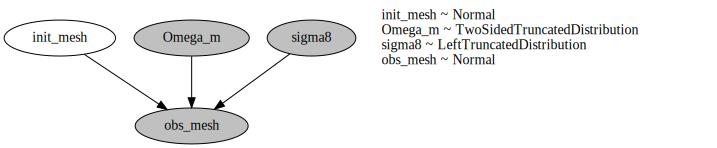

In [13]:
params = dict(init_mesh = jr.normal(jr.key(0), config['mesh_shape']),)
obs = dict(obs_mesh=obs_mesh)
cosmo = dict(Omega_m=0.31, sigma8=0.81)
obs |= cosmo

obs_model = condition(model, obs)
render_model(obs_model, render_distributions=True, render_params=True)

## Posterior mode

In [112]:
potential_fn = lambda params: -log_density(obs_model, (), {}, params)[0]
###################
# TODO: Compute the potential value and gradient function, and jit it
potential_valgrad_fn = jit(value_and_grad(potential_fn))
# potential_valgrad_fn = 
###################

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

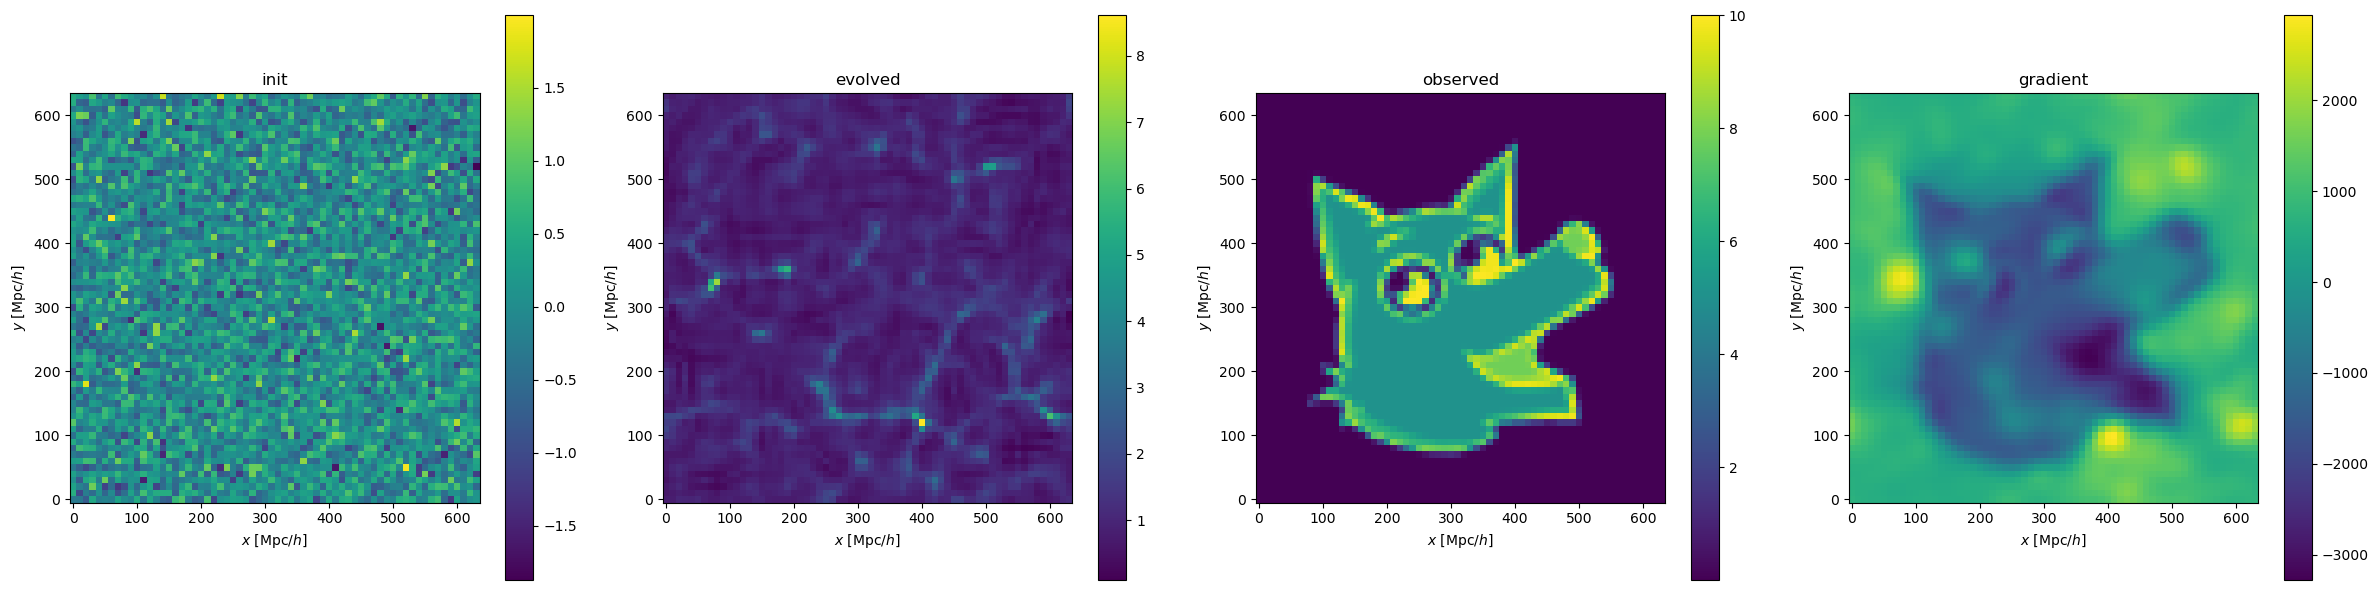

In [113]:
# @ Plot the initial optimization state
get_meshes = partial(mean_model, **cosmo, **config)
def plot_optim_state(params):
    meshes = get_meshes(**params)
    animate_meshes(meshes, **config)
    # plot_meshes(meshes, joint_scale=True, **config)

    meshes = jnp.stack([params['init_mesh'], meshes[-1], obs_mesh, potential_valgrad_fn(params)[1]['init_mesh']])
    titles = ['init', 'evolved', 'observed', 'gradient']
    plot_meshes(meshes, titles, cmap='viridis', **config)

plot_optim_state(params)

In [114]:
# Let us use a simple Adam optimizer
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = .1
n_epochs = 500
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params)

def step(step, opt_state):
    value, grads = potential_valgrad_fn(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:46<00:00, 10.84it/s]


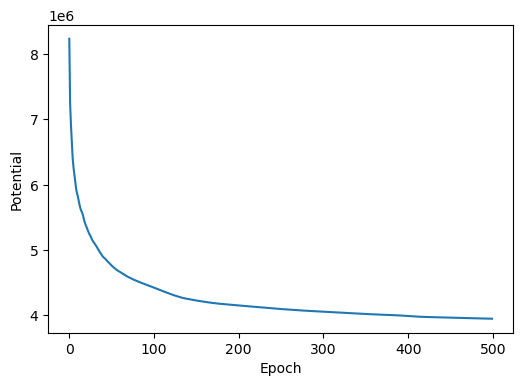

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

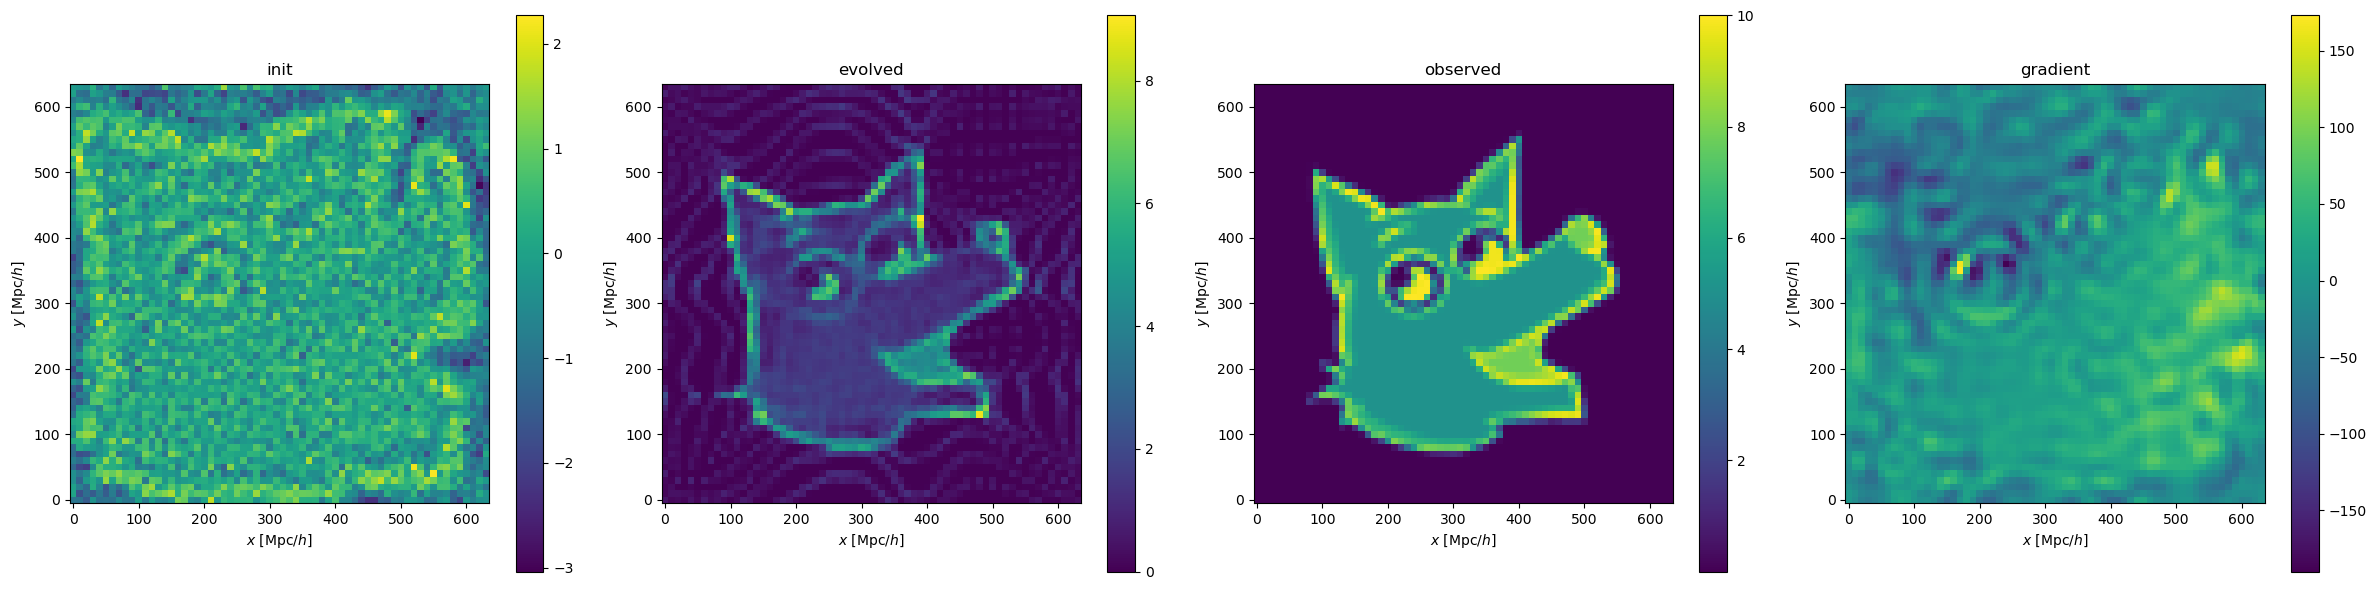

In [115]:
# @ Plot loss and final optimization state
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()
plot_optim_state(params)

## Posterior sampling

In [ ]:
nuts_kernel = infer.NUTS(obs_model, max_tree_depth=5, init_strategy=infer.init_to_sample(),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=50, num_samples=200, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

In [ ]:
nuts_kernel = infer.NUTS(obs_model, max_tree_depth=5, init_strategy=infer.init_to_value(values=params),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=50, num_samples=200, num_chains=4, chain_method='vectorized')
mcmc.run(jr.key(43), extra_fields=['num_steps'])

samples2, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

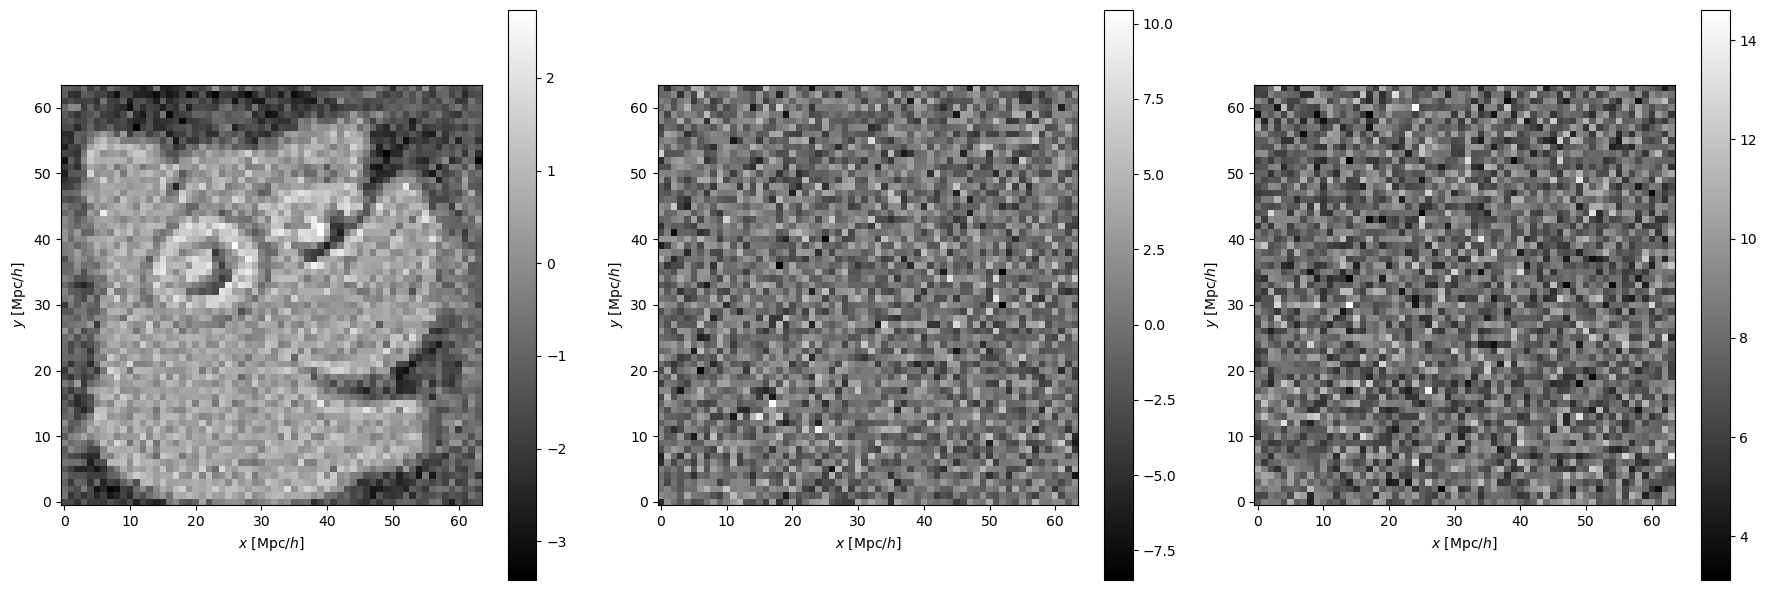

In [11]:
post_meshes = samples['init_mesh']
meshes = jnp.stack([params['init_mesh'], post_meshes.mean(0), post_meshes.std(0)])
titles = ['mode', 'mean', 'std']
plot_meshes(meshes, **config)

In [ ]:
animate_meshes(post_meshes[::10], **config)